<a href="https://colab.research.google.com/github/tmj1432/Capstone-Deep-Learning-/blob/main/Capstone_Phase_1_FINAL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Capstone : Phase 1 

**Problem Statement**

Research shows that 60% of customers will stop doing business with a brand after just one poor customer service experience. Additionally, when it comes to reviews, the fact is that people are more likely to share their bad reviews than their good ones. However, most of these lost customers could have been retained had the problem been resolved or by providing service recovery before it is too late. 

Today, I will be building a deep learning model that will help identify angry customers so that businesses will be able to take action to appease and provide service recovery to these angry customers before they leave the establishment.

---

**Success Metric**

As we are building a model for the use in the customer service industry, it would mean that being able to **correctly identify angry customers** is important. With the ability to identify such customers, establishments are able to **provide service recovery before it is too late**

In this notebook, we are looking to achieve **greater than 80% recall for Angry Faces**.

As recall is the fraction of positive instances that are correctly predicted by the classifier, we want as many correctly predicted angry faces as possible. This is due to the fact that there are **more consequences of not being able to identify angry faces**. 

--- 

In this notebook, we will be building our own custom CNN model using a dataset consisting pictures of my own face. This model will be trained on four facial expressions (Angry, Sad, Neutral and Happy). 

---

## Mount Google Drive

In [1]:
 from google.colab import drive
 
 drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


---

## Import Libraries

In [2]:
 pip install keract

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [24]:
import tensorflow as tf
import cv2
import sys
import os
import matplotlib.pyplot as plt
import numpy as np
import random

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

import keras
from keras.utils import to_categorical
from tensorflow.keras.utils import load_img, img_to_array
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras import activations
from keras.models import load_model
from keras.callbacks import ModelCheckpoint, EarlyStopping

from keract import get_activations, display_heatmaps, display_activations

---

## Visualising Dataset

As mentioned earlier, we are using a dataset with my own facial expressions taken with my iPhone. **The dataset consists of about 150 photos for each facial expression.**

### Function to Crop Face

As pictures are taken from my iPhone, it is not grayscaled or cropped at my face. The function below helps to grayscale and crop pictures. 

---

**Reason for cropping face**

The reason why I cropped the face only is to **reduce image noise**. Noise can distract the model and make it harder to recognize patterns in the data. By removing noise from the images, it can help the model focus on the important features and patterns it needs to learn. Overall, reducing image noise can help improve the performance and generalization ability of a CNN model by eliminating distractions and improving the signal-to-noise ratio in the data.

---

**Benefits of applying grayscale**

1) It **reduces the amount of data the model needs to process**. Grayscale images have only one channel (compared to three channels for a color image), which means they are smaller and require less memory and computational resources to process. This can be especially beneficial if you are working with large datasets or if you are training on hardware with limited resources.

2) It can **simplify the model and make it easier to train**. Using grayscale images can reduce the complexity of the model, which can make it easier to train and debug.

3) It can **improve the generalization ability of the model**. By removing the color information from the images, you are forcing the model to rely on other features (such as shape, texture, and edges) to recognize patterns in the data. This can help the model learn more generalizable features and perform better on new, unseen data.

---

In [4]:
def detectFaceOpenCVHaar(framepath, inHeight=300, inWidth=0):
    frame = cv2.imread(framepath)
    frameOpenCVHaar = frame.copy()
    frameHeight = frameOpenCVHaar.shape[0]
    frameWidth = frameOpenCVHaar.shape[1]
    if not inWidth:
        inWidth = int((frameWidth / frameHeight) * inHeight)

    scaleHeight = frameHeight / inHeight
    scaleWidth = frameWidth / inWidth

    frameOpenCVHaarSmall = cv2.resize(frameOpenCVHaar, (inWidth, inHeight))
    frameGray = cv2.cvtColor(frameOpenCVHaarSmall, cv2.COLOR_BGR2GRAY)

    faceCascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
    faces = faceCascade.detectMultiScale(frameGray)
    bboxes = []
    for (x, y, w, h) in faces:
        x1 = x
        y1 = y
        x2 = x + w
        y2 = y + h
        cvRect = [int(x1 * scaleWidth), int(y1 * scaleHeight),
                  int(x2 * scaleWidth), int(y2 * scaleHeight)]
        bboxes.append(cvRect)
        cv2.rectangle(frameOpenCVHaar, (cvRect[0], cvRect[1]), (cvRect[2], cvRect[3]), (0, 255, 0),
                      int(round(frameHeight / 150)), 4)
      
    cropped_image = frameOpenCVHaar[cvRect[1]:cvRect[3], cvRect[0]:cvRect[2]]
    cropped_image = cv2.cvtColor(cropped_image, cv2.COLOR_BGR2GRAY)
    return cropped_image

### Function to Plot Images

In [5]:
def img_show(path):
  # apply predefined crop function
  cropped = detectFaceOpenCVHaar(path)  
  plt.imshow(cropped, cmap="gray", vmin=0, vmax=255)

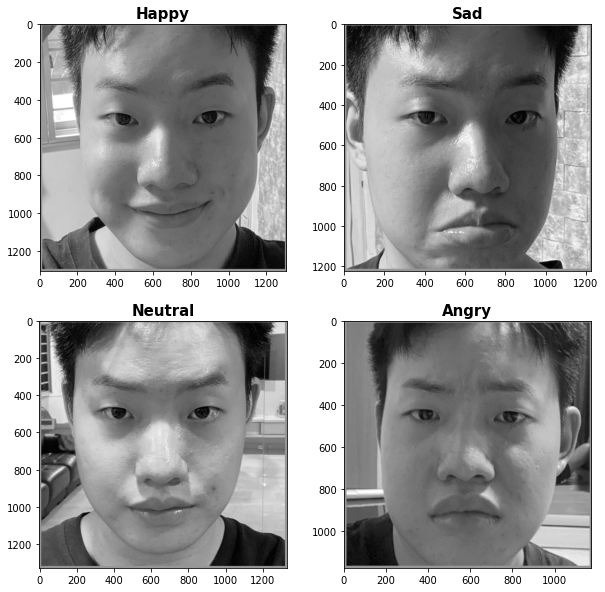

In [6]:
plt.figure(figsize=(10,10))

plt.subplot(2,2,1)
img_show('/content/gdrive/MyDrive/Colab Notebooks/Capstone/phase 1/train/happy/IMG_9468.JPG')
plt.title('Happy', fontsize=15, fontweight='bold')

plt.subplot(2,2,2)
img_show('/content/gdrive/MyDrive/Colab Notebooks/Capstone/phase 1/train/sad/IMG_9847.JPG')
plt.title('Sad', fontsize=15, fontweight='bold')

plt.subplot(2,2,3)
img_show('/content/gdrive/MyDrive/Colab Notebooks/Capstone/phase 1/train/neutral/IMG_0656.JPG')
plt.title('Neutral', fontsize=15, fontweight='bold')

plt.subplot(2,2,4)
img_show('/content/gdrive/MyDrive/Colab Notebooks/Capstone/phase 1/train/angry/IMG_0001.JPG')
plt.title('Angry', fontsize=15, fontweight='bold');

The plot above visualises the four emotions we will be training our model with in this notebook.

---

## Image Pre-processing

In order for our model to interpret images, we have to process them accordingly.

### Function to create Image Data

Here we are using a custom function to create our train-val and test data.
This function applies our face crop function and resize them before converting them into an array.

In [7]:
def create_image_data(data,img_size, datadirectory, classes):
    for category in classes:
        path = os.path.join(datadirectory, category)
        class_num = classes.index(category)
        for img in os.listdir(path):
            try:
              #function to crop face and grayscale
                img_array = detectFaceOpenCVHaar(os.path.join(path, img))
                new_array = cv2.resize(img_array, (img_size, img_size))
                data.append([new_array,class_num])
            except Exception as e:
                pass

In [8]:
# classes in dataset
classes = ['angry','happy','neutral','sad']

### Create Train and Test Array

In [9]:
# read all the images and convert them to array
training_data = [] 

# path
datadirectory_train = '/content/gdrive/MyDrive/Colab Notebooks/Capstone/phase 1/train' 

# using pre-defined function 
create_image_data(training_data, 224, datadirectory_train, classes)

In [10]:
# shuffle training data 
random.Random(42).shuffle(training_data)

Shuffling the training data can help improve the generalization ability and efficiency of our model

In [11]:
# read all the images and convert them to array
testing_data = [] 

# path
datadirectory_test = '/content/gdrive/MyDrive/Colab Notebooks/Capstone/phase 1/test' 

# using pre-defined function 
create_image_data(testing_data, 224, datadirectory_test, classes)

In [12]:
# shuffle training data 
random.Random(42).shuffle(testing_data)

### Train-Val Split

In [13]:
X = []
y = []

for features, label in training_data:
    X.append(features)
    y.append(label)

In [14]:
# X forms the training images, and y forms the training labels
X = np.array(X)
y = to_categorical(y)

In [15]:
# train-test split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

### Test Data

In [16]:
X_test = []
y_test = []

for features, label in testing_data:
    X_test.append(features)
    y_test.append(label)

In [17]:
# X forms the testing images, and y forms the testing labels
X_test = np.array(X_test)
y_test = to_categorical(y_test)

### Normalisation

In [18]:
# Each image's dimension is 224 x 224
img_rows, img_cols = 224, 224
# The input shape of a neural network refers to the dimensions of the input data that the network expects to receive.
input_shape = (img_rows, img_cols, 1)

# Prepare the training images
X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
X_train = X_train.astype('float32')
X_train /= 255

# Prepare the validation images
X_val = X_val.reshape(X_val.shape[0], img_rows, img_cols, 1)
X_val = X_val.astype('float32')
X_val /= 255

# Prepare the test images
X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)
X_test = X_test.astype('float32')
X_test /= 255

### Image Augmentation

**Benefits of Image Augmentation**

1) It can **increase the size of the training dataset**, which can help the model learn more effectively.

2) It can **help the model generalize better to new, unseen data**. By generating a diverse set of training examples through image augmentation, the model can learn to recognize patterns and features that are invariant to transformations such as translation, rotation, and scaling.

3) It can **help the model learn more robust features**. By applying transformations to the training data, the model can learn to recognize patterns and features that are invariant to these transformations, which can make the model more robust and less sensitive to variations in the data.

4) It can **help reduce overfitting**. By generating a larger and more diverse training dataset through image augmentation, the model may be less likely to overfit to the specific characteristics of the training data.

### Visualising Image Augmentation

Let us visualise the image augmentation on one picture. 

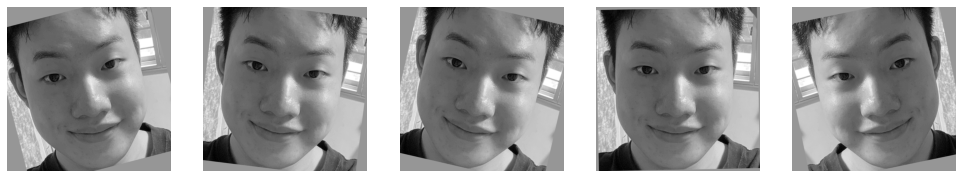

In [19]:

#Loads in image path
img = detectFaceOpenCVHaar('/content/gdrive/MyDrive/Colab Notebooks/Capstone/phase 1/train/happy/IMG_9468.JPG')
img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
img_tensor = img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)
#Uses ImageDataGenerator to flip the images
datagen = ImageDataGenerator(horizontal_flip=True,rotation_range=15)
#Creates our batch of one image
pic = datagen.flow(img_tensor, batch_size =1)
plt.figure(figsize=(17,17))
#Plots our figures
for i in range(1,6):
  plt.subplot(1, 5, i)
  batch = pic.next()
  image_ = batch[0].astype('uint8')
  plt.imshow(image_[:,:,0], cmap="gray", vmin=0, vmax=255)
  plt.axis('off')

We chose horizontal flip as it is not realistic for a person's face to be filmed upside down while horizontal flip allows the model to learn from different angles of the face. And rotation range of 15 helps to increase variation of the pictures to help increase generalizability of the model.

### Apply Image Augmentation

In [20]:
gen = ImageDataGenerator(horizontal_flip=True,
                         rotation_range=15)

batches = gen.flow(X_train, y_train, batch_size=32)
val_batches = gen.flow(X_val, y_val, batch_size=32)

**To summarize this section**

Firstly, we applied our pre-defined function to crop and grayscale images from the original dataset and convert them into an array.

Secondly, we applied train-val split to our training data for modeling and prepared our test data.

Thirdly, we applied image augmentation to our image data.

Lastly, normalized our data by dividing it by 255.



---

## Modeling

### Convolutional Neural Networks

A convolutional neural network is a type of artificial neural network specifically designed for processing data that has a grid-like topology, such as an image. CNNs are particularly useful for image classification.

In a CNN, the input data is processed through multiple layers of interconnected nodes, each of which performs a specific operation on the data.

The layers of a CNN can include **convolutional layers**, **pooling layers**, and **fully connected layers**. Convolutional layers apply a set of filters to the input data, pooling layers reduce the dimensionality of the data, and fully connected layers learn a non-linear mapping between the input and output data.

---
**Convolution**

Convolution is performed by applying a set of filters (also known as kernels or weights) to the input data and computing the dot product between the filter and a small region of the input data.

Convolution is typically applied in a sliding window fashion, where the filters are moved across the input data in a predetermined step size (the stride). At each position, the dot product between the filter and the region of the input data is computed and output as a single value. This process is repeated for all positions in the input data, resulting in a set of output values that form a new, filtered version of the input data.

**Convolutional Layers**

We will be experimenting between two models with varying numbers of convolutional layers. Ultimately, the best way for us to determine the optimal number of convolutional layers for our model is to try out different configurations and see which one performs best on our dataset.

---
**Pooling**

Pooling is a technique that is commonly used in convolutional neural networks (CNNs) to down-sample the spatial dimensions of the data and extract more robust features from the data.

**Max Pooling**

In max pooling, the maximum value within each region of the input data is selected and output as the pooled value.

Max pooling is used due to its ability to preserve the most important features in the data and suppress noise or less important features. 

This can be particularly useful for tasks such as facial emotion recognition, where the features of interest (e.g., facial features, facial expressions) may be more variable or less well-defined.

---

**Dropout**

Dropout is a **regularization technique** that is often used in neural networks to reduce overfitting and improve generalization performance. In a neural network, dropout works by randomly setting a certain percentage of the neurons in a layer to zero during training, which forces the network to rely on the remaining neurons and can prevent the network from relying too heavily on any one neuron or feature.

---

**Flatten**

The flatten operation is used to **convert the multidimensional output of the convolutional and pooling layers into a one-dimensional array** that can be fed into the fully connected (dense) layers.

---

**Dense Layer**

A dense layer (also known as a fully connected layer) is a type of **layer in a neural network that is composed of neurons that are connected to all the neurons in the previous layer**. In a dense layer, each neuron receives input from all the neurons in the previous layer, and each neuron provides output to all the neurons in the next layer.

Dense layers are often used in convolutional neural networks (CNNs) to learn a non-linear mapping between the input and output data. They are typically placed after one or more convolutional or pooling layers, which have already extracted features from the input data.

---

### Compiling

Compiling a convolutional neural network (CNN) refers to the process of configuring the CNN for training. During the compilation process, you specify the loss function and optimizer that the CNN will use during training.

**Loss Function**

The loss function is a measure of how well the CNN is performing on the training data. It is used to calculate the error between the predicted output of the CNN and the true output, and to guide the optimization process. The loss function we are using is categorical cross-entropy for our classification task.

**Optimizer**

The optimizer is an algorithm that is used to update the weights of the CNN during training. It determines how the CNN will adjust its weights to reduce the loss and improve its performance on the training data.

**Metrics**

The metrics parameter specifies a list of metrics to track during training and evaluation.

---

### Callback

Callback allows you to terminate the training process if the model's performance on a validation dataset stops improving. This can **help you to avoid overfitting**, where the model begins to memorize the training data rather than learning generalizable features.

In [31]:
early_stopping = EarlyStopping(monitor='loss', patience=3)

#define the model checkpoint callback -> this will keep on saving the model as a physical file
model_checkpoint_model1 = ModelCheckpoint('model1_phase1.h5', verbose=1, save_best_only=True)

model_checkpoint_model2 = ModelCheckpoint('model2_phase1.h5', verbose=1, save_best_only=True)

In [26]:
# number of possible predictions output
num_classes = 4

### Function for Plotting Training Curves

In [27]:
def plot_training_curves(history,model_name):
  plt.figure(figsize=(16,8))

  plt.subplot(2,2,1)
  plt.plot(history.history['accuracy'], label='Train accuracy')
  plt.plot(history.history['val_accuracy'], label='Val accuracy')
  plt.legend()
  plt.title(f'{model_name} (Accuracy)', fontweight='bold', fontsize=10)

  plt.subplot(2,2,2)
  plt.plot(history.history['loss'], label='Train loss')
  plt.plot(history.history['val_loss'], label='Val Loss')
  plt.legend()
  plt.title(f'{model_name} (Loss)', fontweight='bold', fontsize=10);

### Model 1

In [32]:
model1 = Sequential()

# Add convolutional layers
model1.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape, padding='same')) # input shape defined in one of the cells above
model1.add(MaxPooling2D((2, 2)))
model1.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model1.add(MaxPooling2D((2, 2)))

# Flatten the output and add fully connected layers
model1.add(Flatten())
model1.add(Dense(64, activation='relu'))
model1.add(Dense(num_classes, activation='softmax'))

# Compile the model
model1.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(learning_rate=0.001),
              metrics=['accuracy'])

In [33]:
history_1 = model1.fit(batches,
           batch_size=32,
           epochs=20,
           validation_data=val_batches,
           validation_steps=len(X_train)/32,
           use_multiprocessing=True,
           callbacks=[early_stopping, model_checkpoint_model1])

Epoch 1/20
16/16 [==============================] - ETA: 0s - loss: 2.4743 - accuracy: 0.2598
Epoch 1: val_loss improved from inf to 1.38210, saving model to model1_phase1.h5
16/16 [==============================] - 57s 3s/step - loss: 2.4743 - accuracy: 0.2598 - val_loss: 1.3821 - val_accuracy: 0.3301
Epoch 2/20
16/16 [==============================] - ETA: 0s - loss: 1.3777 - accuracy: 0.3150
Epoch 2: val_loss improved from 1.38210 to 1.35301, saving model to model1_phase1.h5
16/16 [==============================] - 57s 3s/step - loss: 1.3777 - accuracy: 0.3150 - val_loss: 1.3530 - val_accuracy: 0.3281
Epoch 3/20
16/16 [==============================] - ETA: 0s - loss: 1.3167 - accuracy: 0.3524
Epoch 3: val_loss improved from 1.35301 to 1.24253, saving model to model1_phase1.h5
16/16 [==============================] - 53s 3s/step - loss: 1.3167 - accuracy: 0.3524 - val_loss: 1.2425 - val_accuracy: 0.4590
Epoch 4/20
16/16 [==============================] - ETA: 0s - loss: 1.2054 - acc

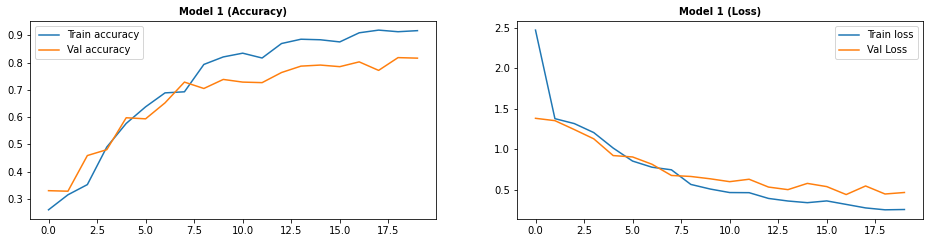

In [42]:
plot_training_curves(history_1,'Model 1')

Based on the learning curves we can see that there is some **overfitting** where there is a big gap between the train and val accuracy. This trend was also shown on the loss function where there is a gap between train and val loss.

### Model 2

In order to improve from Model 1, we will be implementing dropout which will help **regularize and reduce overfitting**.

In [38]:
model2 = Sequential()

# Add convolutional layers
model2.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape, padding='same')) # input shape defined in one of the cells above
model2.add(MaxPooling2D((2, 2)))
model2.add(Conv2D(64, (3, 3), activation='relu',padding='same'))
model2.add(MaxPooling2D(pool_size=(2, 2)))
model2.add(Dropout(0.25))


# Flatten the output and add fully connected layers
model2.add(Flatten())

model2.add(Dense(128, activation='relu'))
model2.add(Dropout(0.5))
model2.add(Dense(num_classes, activation='softmax'))

# Compile the model
model2.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(learning_rate=0.001),
              metrics=['accuracy'])

In [39]:
history_2 = model2.fit(batches,
           batch_size=32,
           epochs=20,
           validation_data=val_batches,
           validation_steps=len(X_train)/32,
           use_multiprocessing=True,
           callbacks=[early_stopping, model_checkpoint_model2])

Epoch 1/20
16/16 [==============================] - ETA: 0s - loss: 2.4403 - accuracy: 0.2638
Epoch 1: val_loss improved from inf to 1.38371, saving model to model2_phase1.h5
16/16 [==============================] - 71s 4s/step - loss: 2.4403 - accuracy: 0.2638 - val_loss: 1.3837 - val_accuracy: 0.2793
Epoch 2/20
16/16 [==============================] - ETA: 0s - loss: 1.3634 - accuracy: 0.3169
Epoch 2: val_loss improved from 1.38371 to 1.32724, saving model to model2_phase1.h5
16/16 [==============================] - 60s 4s/step - loss: 1.3634 - accuracy: 0.3169 - val_loss: 1.3272 - val_accuracy: 0.3359
Epoch 3/20
16/16 [==============================] - ETA: 0s - loss: 1.2956 - accuracy: 0.3898
Epoch 3: val_loss improved from 1.32724 to 1.28185, saving model to model2_phase1.h5
16/16 [==============================] - 60s 4s/step - loss: 1.2956 - accuracy: 0.3898 - val_loss: 1.2819 - val_accuracy: 0.4258
Epoch 4/20
16/16 [==============================] - ETA: 0s - loss: 1.2304 - acc

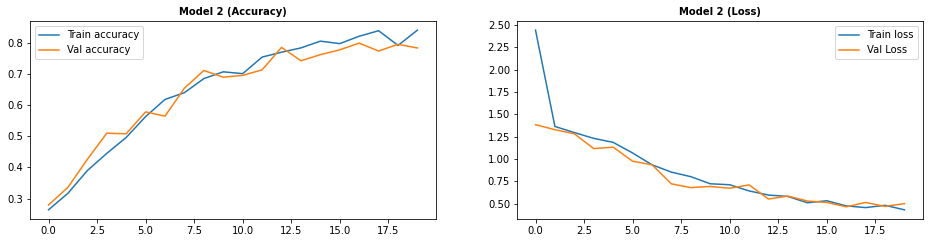

In [41]:
plot_training_curves(history_2,'Model 2')

Based on the learning curves, we can see that there is a smaller gap between the train and the val curves on both the accuracy and the loss function. This shows that our regularisation techniques has helped us to get a better fit. 

By **reducing overfitting, we can improve the generalizability** of our model, as it is more likely to make accurate predictions on new, unseen data.

---

## Model Evaluation

### Evaluation Functions

In [71]:
def plot_confusion_matrix(model, y_test):
  y_pred = model.predict(X_test, verbose=0)
  y_test =np.argmax(y_test, axis=1)
  # use argmax to retrieve corresponding index for max value of each test sample
  y_classes = [np.argmax(element) for element in y_pred]
  cm = confusion_matrix(y_test,y_classes, labels=[0,1,2,3])
  disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                display_labels=['Angry','Happy','Neutral','Sad'])
  
  disp.plot()
  plt.title('Confusion Matrix', fontsize=15, fontweight='bold')
  plt.show()
  

def get_classification_report(model, y_test):
  y_pred = model.predict(X_test, verbose=0)
  y_test =np.argmax(y_test, axis=1)
  # use argmax to retrieve corresponding index for max value of each test sample
  y_classes = [np.argmax(element) for element in y_pred]
  print("Classification Report: \n", classification_report(y_test, y_classes, target_names=['Angry',
                                                                                          'Happy',
                                                                                          'Neutral',
                                                                                          'Sad']))


In [49]:
#Load the model that was saved by ModelCheckpoint
final_model = load_model('/content/gdrive/MyDrive/Colab Notebooks/Capstone/model2_phase1.h5')

In [67]:
get_classification_report(final_model, y_test)

Classification Report: 
               precision    recall  f1-score   support

       Angry       0.49      1.00      0.65        33
       Happy       1.00      0.61      0.75        33
     Neutral       0.60      0.36      0.45        33
         Sad       0.88      0.64      0.74        33

    accuracy                           0.65       132
   macro avg       0.74      0.65      0.65       132
weighted avg       0.74      0.65      0.65       132



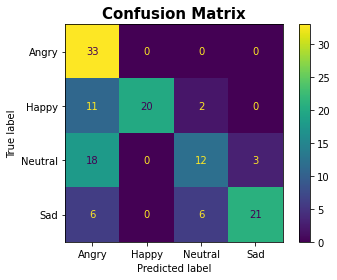

In [70]:
plot_confusion_matrix(final_model, y_test)

Based on the classification report, we see that the **recall score for Angry faces is 1**. This means that out of all instances that I am showing an angry face the model was able to predict all of them as angry faces. This is actually good for us as we are building this model for the use of customer service where it is crucial to attend to angry customers. 

However, by looking at the confusion matrix, we see that there are quite a few neutral faces being predicted as angry faces. But, there is **more costs involved in not being able to predict angry faces** than any other facial expressions. If a customer leaves angry, there could be potential risk of the customer writing a bad review on the establishment. If the establishment was able to identify these angry and sad customers, they might be able to provide service recovery before it is too late.

Next, we will look at the prediction for sad faces. If an establishment wishes to go the extra mile for customers to impress them, identifying customers who are sad and showing effort to make their day would definitely create great customer experiences for them. From the confusion matrix, we see that **21 out of 33 sad faces were predicted as sad faces** by the model. Additionally, 6 of the sad faces were predicted as angry. However, having the **6 wrongly classified sad faces as angry faces does not pose as a case for concern** in contrary, it may even help staff become aware that a particular customer is sad while they were checking out for potential angry customers.

In total, there were 66 faces in total for both angry and sad faces. **Out of 66, 54 were correctly predicted**. This means that the model was **able to predict 82% of such angry and sad faces**. 

If we were to include the 6 sad faces that were predicted as angry faces, it would mean that **60 out of 66 angry and sad faces were predicted as angry and sad faces**. This would bring the percentage up to **90%**.

---

### Visualise Predictions

In [ ]:
# predict Y using CNN model on test data
y_pred = final_model.predict(X_test)

y_test =np.argmax(y_test, axis=1)
# use argmax to retrieve corresponding index for max value of each test sample
y_classes = [np.argmax(element) for element in y_pred]

# predicted Y values is a normalised prob distr of values between 0 to 1 as a result of softmax activation function used
wrong_classified = np.nonzero(y_classes != y_test)[0]
correct_classified = np.nonzero(y_classes==y_test)[0]

### Correct Predictions

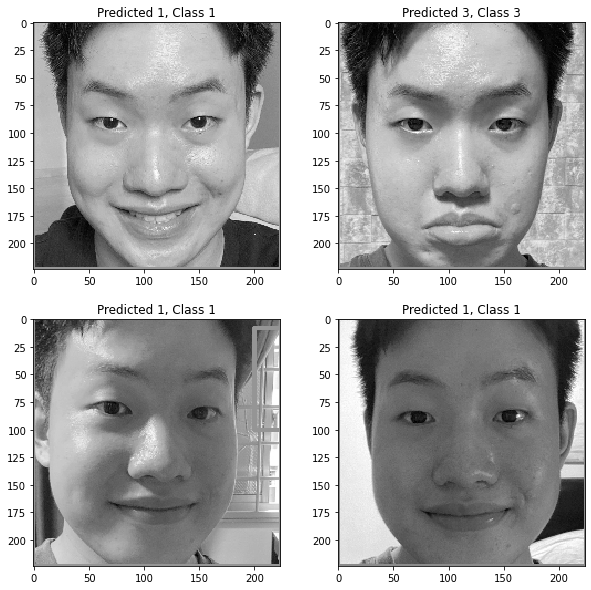

In [83]:
plt.figure(figsize=(10,10))
for i, correct in enumerate(correct_classified[25:29]):
    plt.subplot(2,2,i+1)
    plt.imshow(X_test[correct].reshape(224,224), cmap='gray', interpolation='none')
    plt.title("Predicted {}, Class {}".format(y_classes[correct], y_test[correct]))

### Wrong Predictions

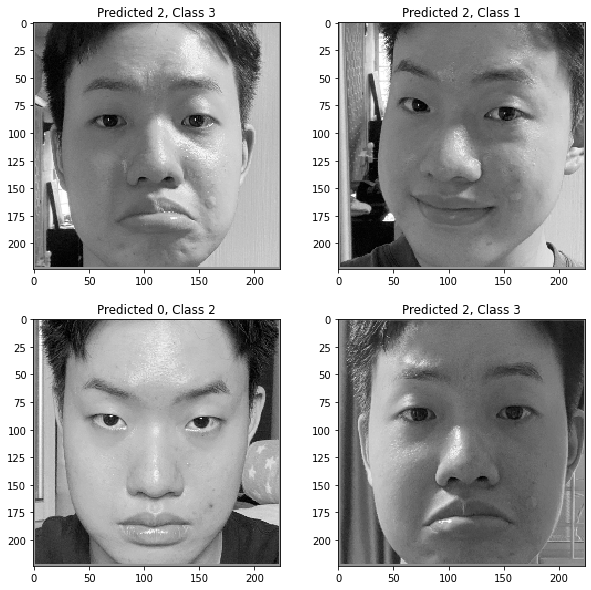

In [85]:
plt.figure(figsize=(10,10))
for i, incorrect in enumerate(wrong_classified[20:24]):
    plt.subplot(2,2,i+1)
    plt.imshow(X_test[incorrect].reshape(224,224), cmap='gray', interpolation='none')
    plt.title("Predicted {}, Class {}".format(y_classes[incorrect], y_test[incorrect]))

---

## Visualise Activations

Activations in a convolutional neural network (CNN) refer to the output of a particular layer in the network. Activations can be thought of as the "features" that the network has learned to recognize at a particular layer. In other words, activations represent the intermediate representations of the input data that the network has learned during training.

### Heatmap

conv2d_7_input (1, 224, 224, 1) 


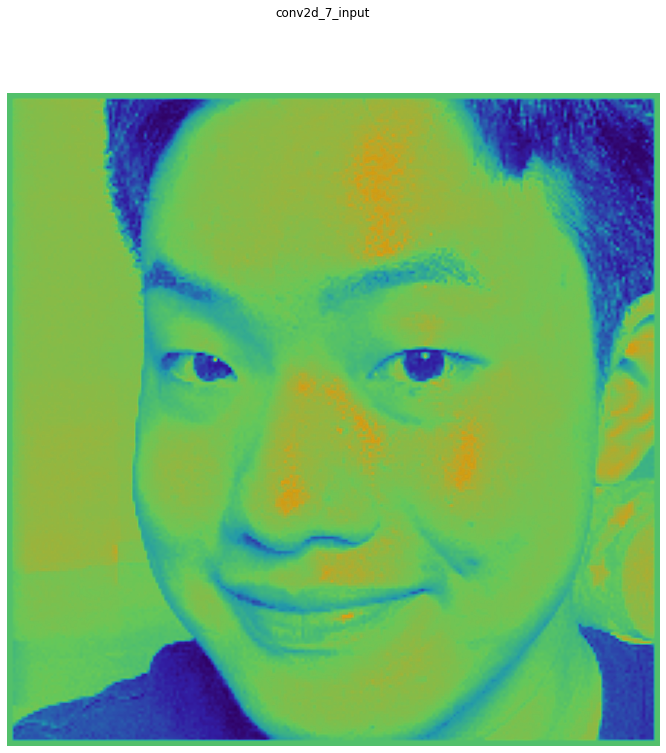

conv2d_7 (1, 224, 224, 32) 


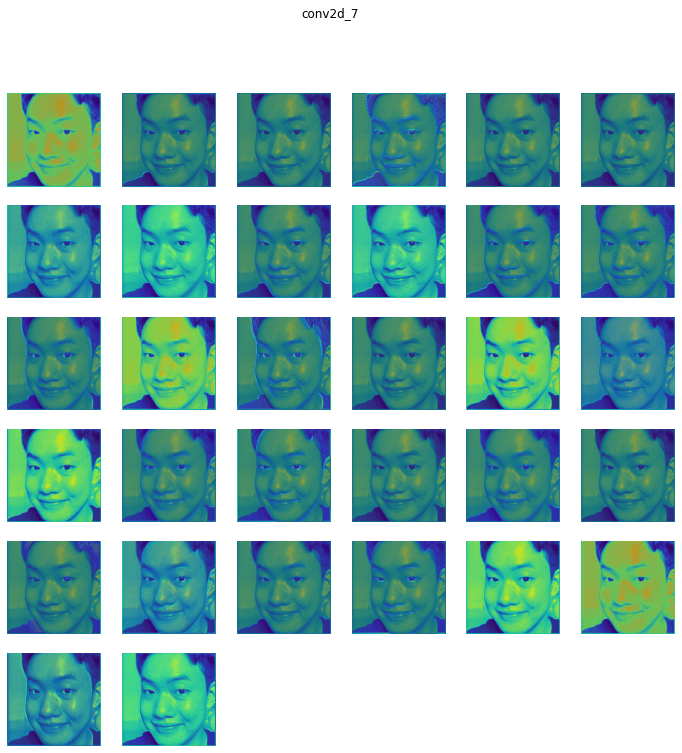

max_pooling2d_7 (1, 112, 112, 32) 


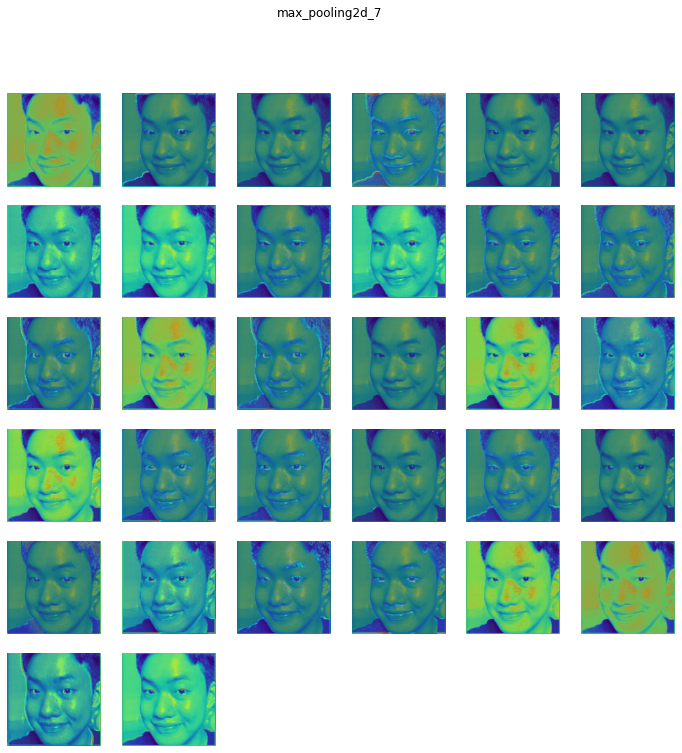

conv2d_8 (1, 112, 112, 64) 


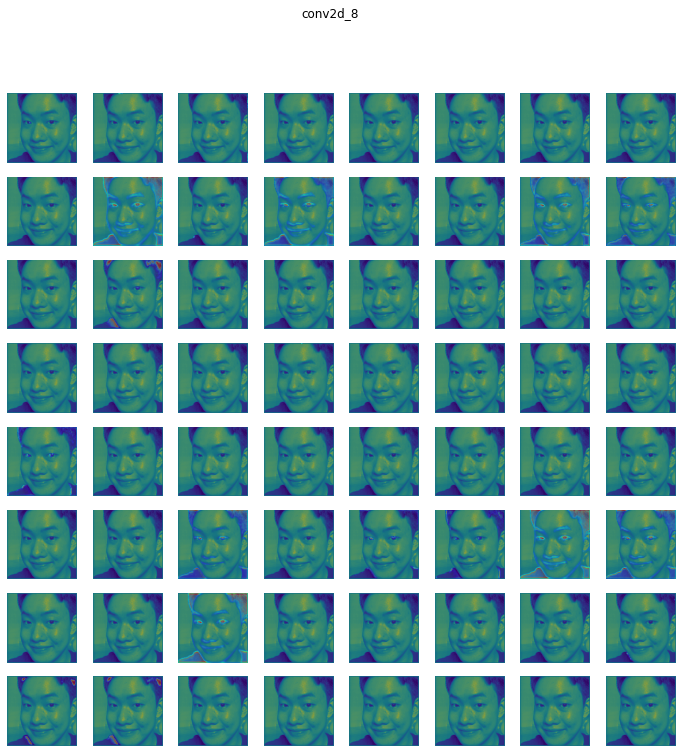

max_pooling2d_8 (1, 56, 56, 64) 


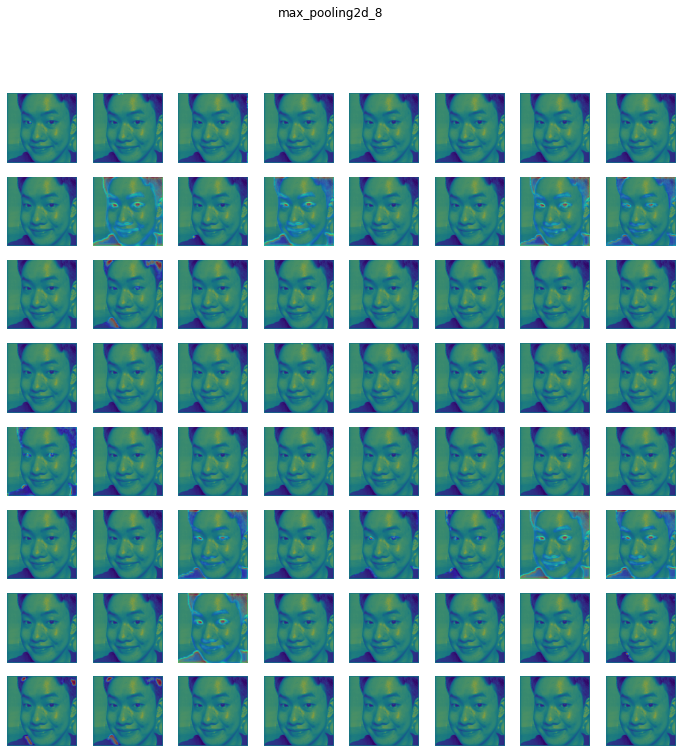

dropout (1, 56, 56, 64) 


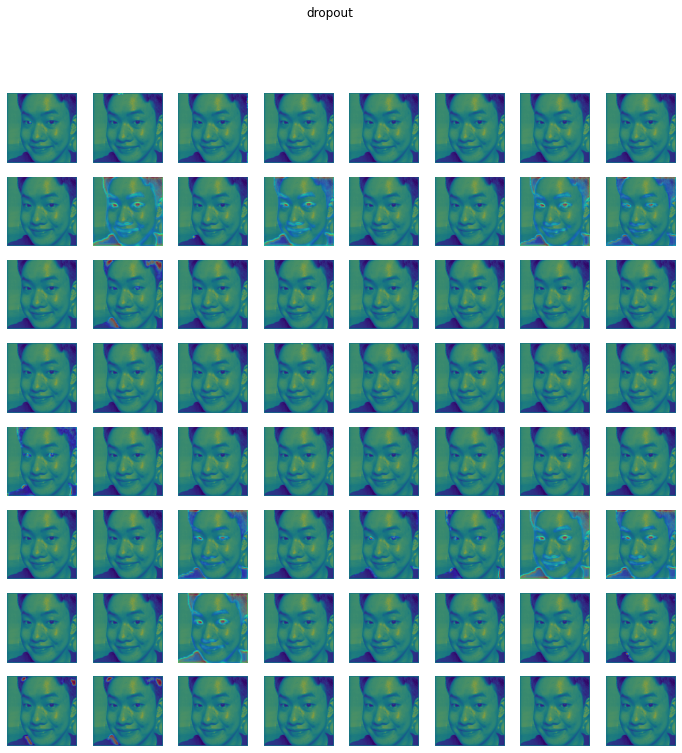

flatten_3 (1, 200704) -> Skipped. 2D Activations.
dense_6 (1, 128) -> Skipped. 2D Activations.
dropout_1 (1, 128) -> Skipped. 2D Activations.
dense_7 (1, 4) -> Skipped. 2D Activations.


In [89]:
keract_inputs = X_test[1:2]
keract_targets = y_test[:0]
activations = get_activations(final_model, keract_inputs)
display_heatmaps(activations, keract_inputs, directory='.', save=False, fix=True, merge_filters=False)

### Display Activations

conv2d_7_input (1, 224, 224, 1) 


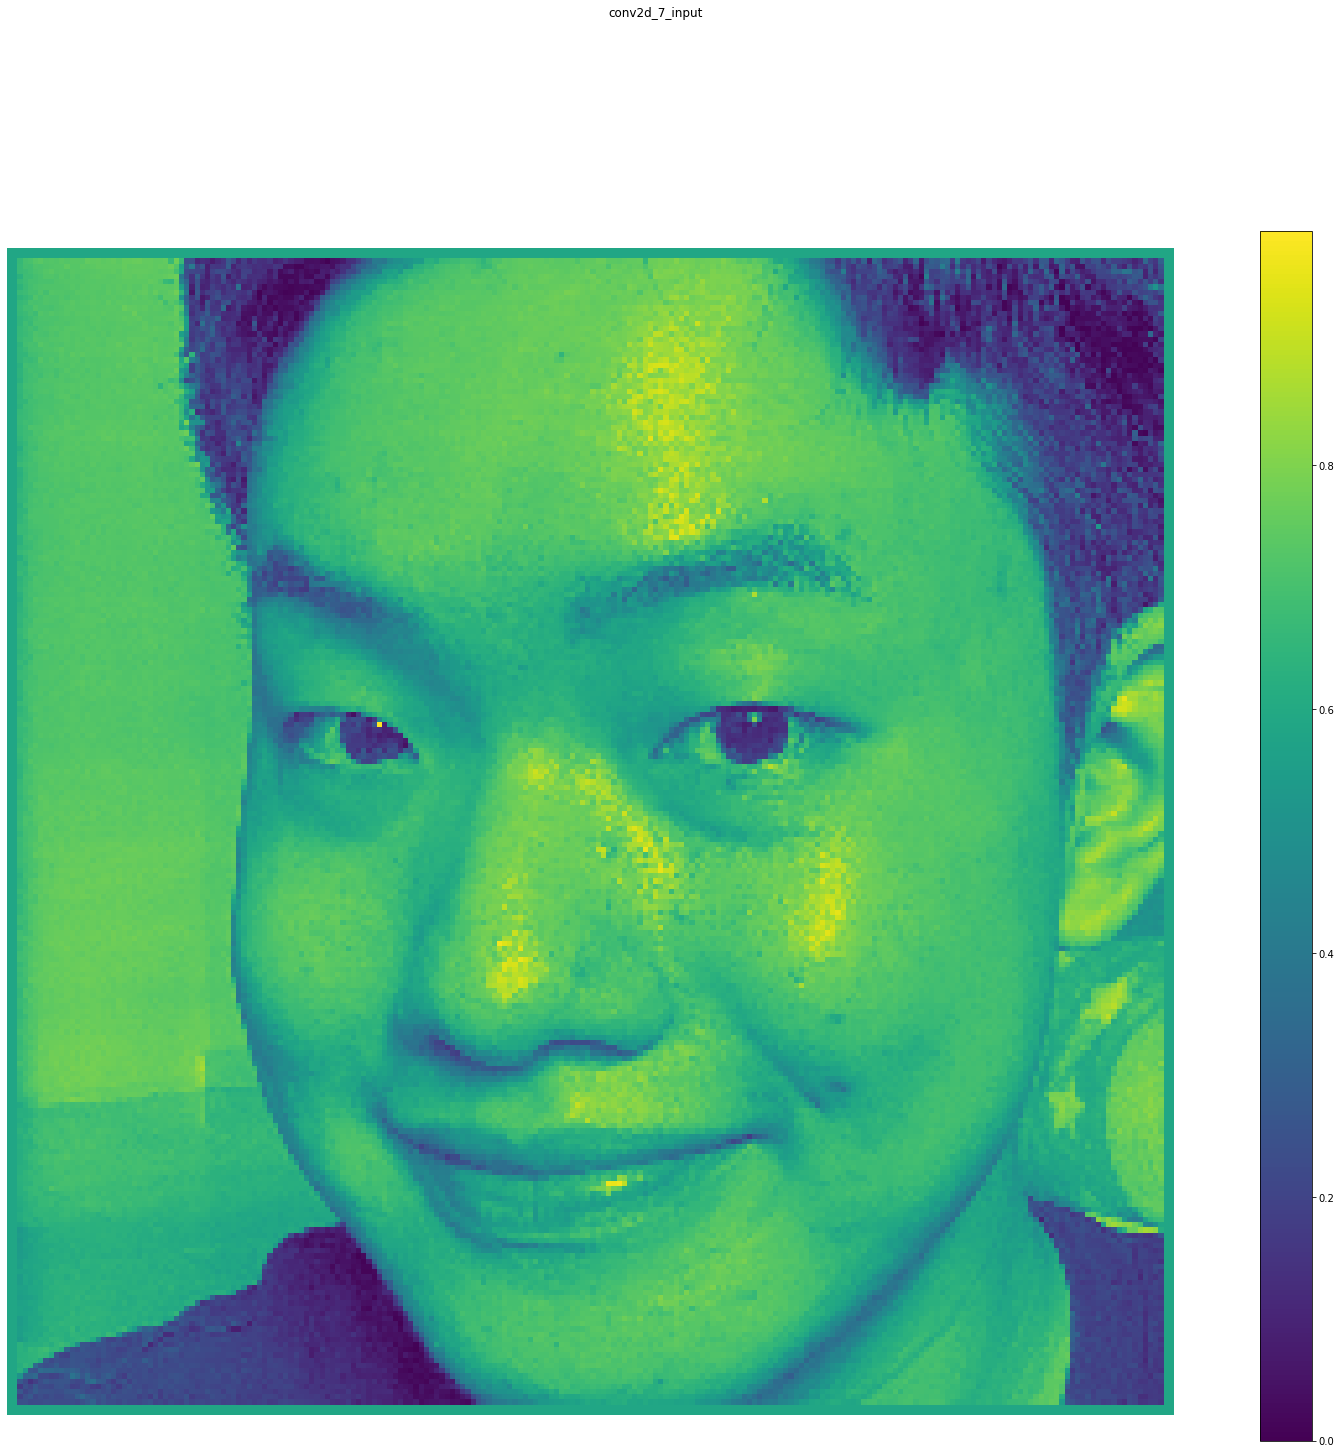

conv2d_7 (1, 224, 224, 32) 


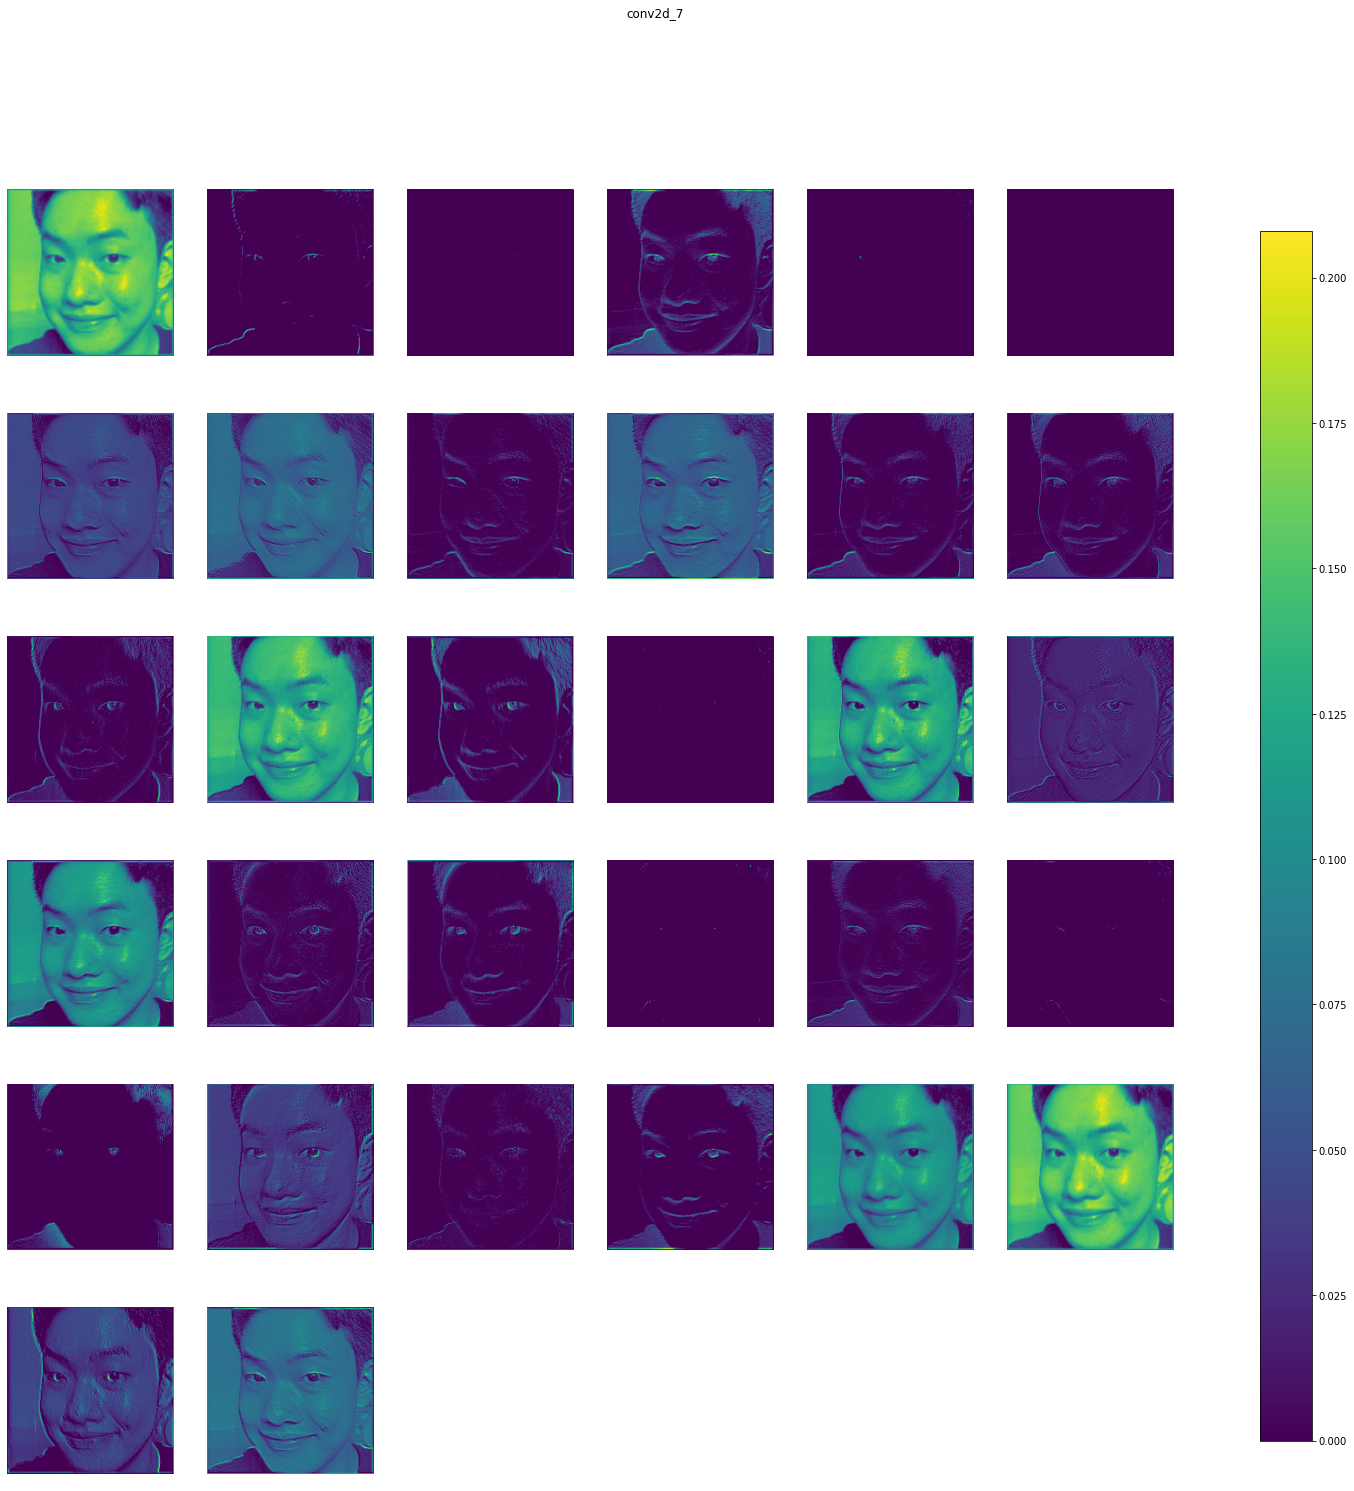

max_pooling2d_7 (1, 112, 112, 32) 


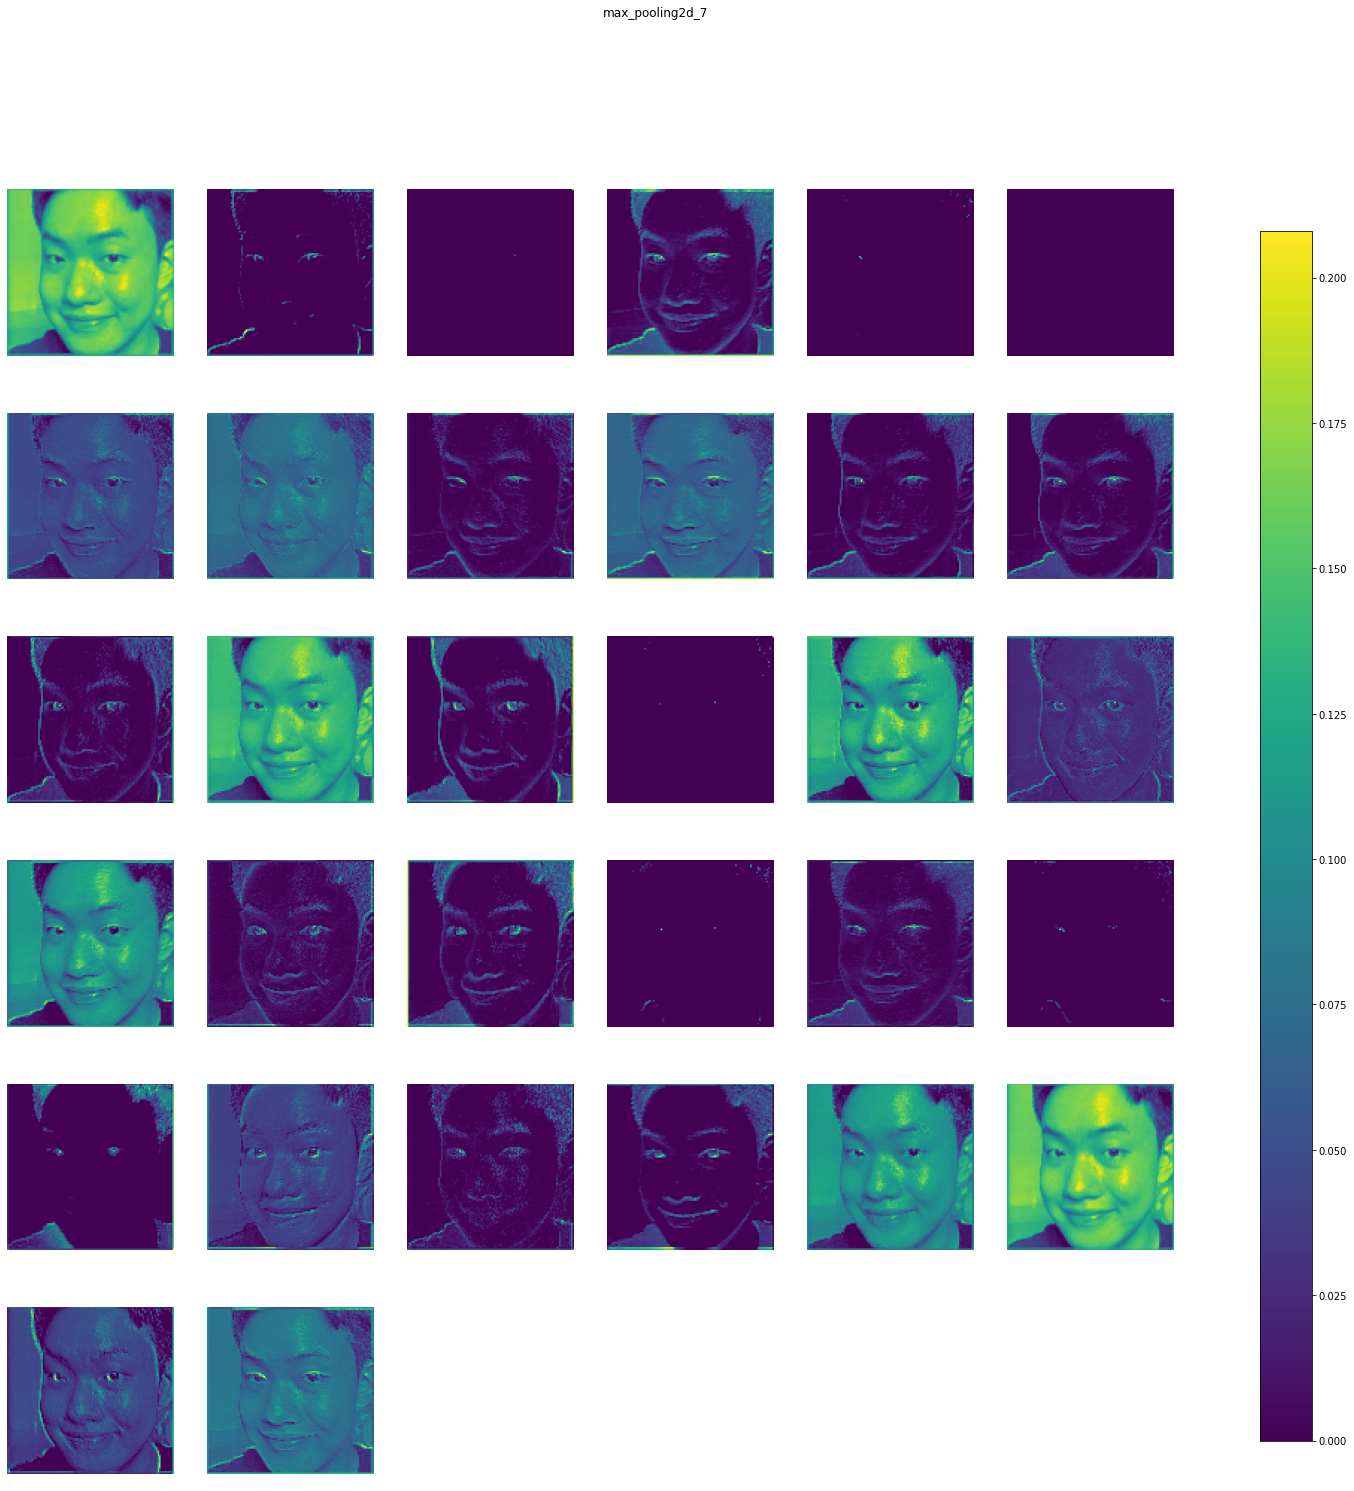

conv2d_8 (1, 112, 112, 64) 


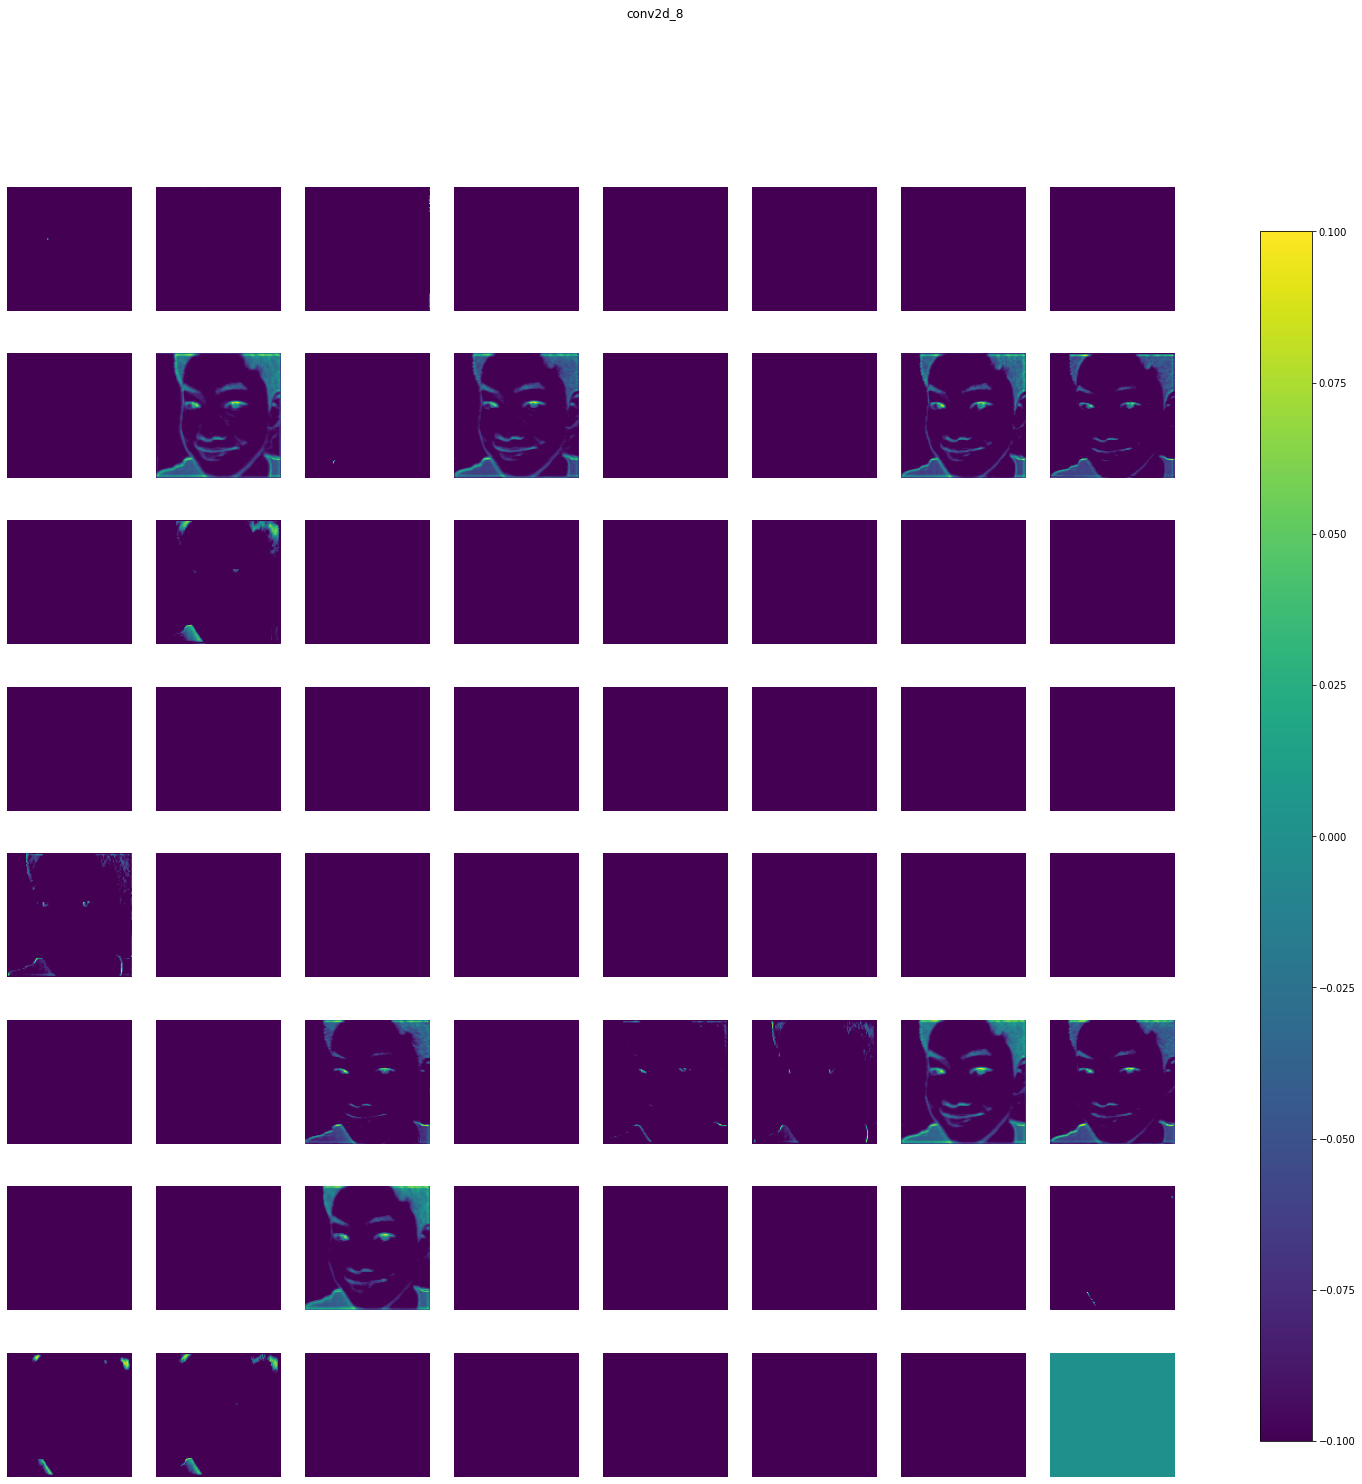

max_pooling2d_8 (1, 56, 56, 64) 


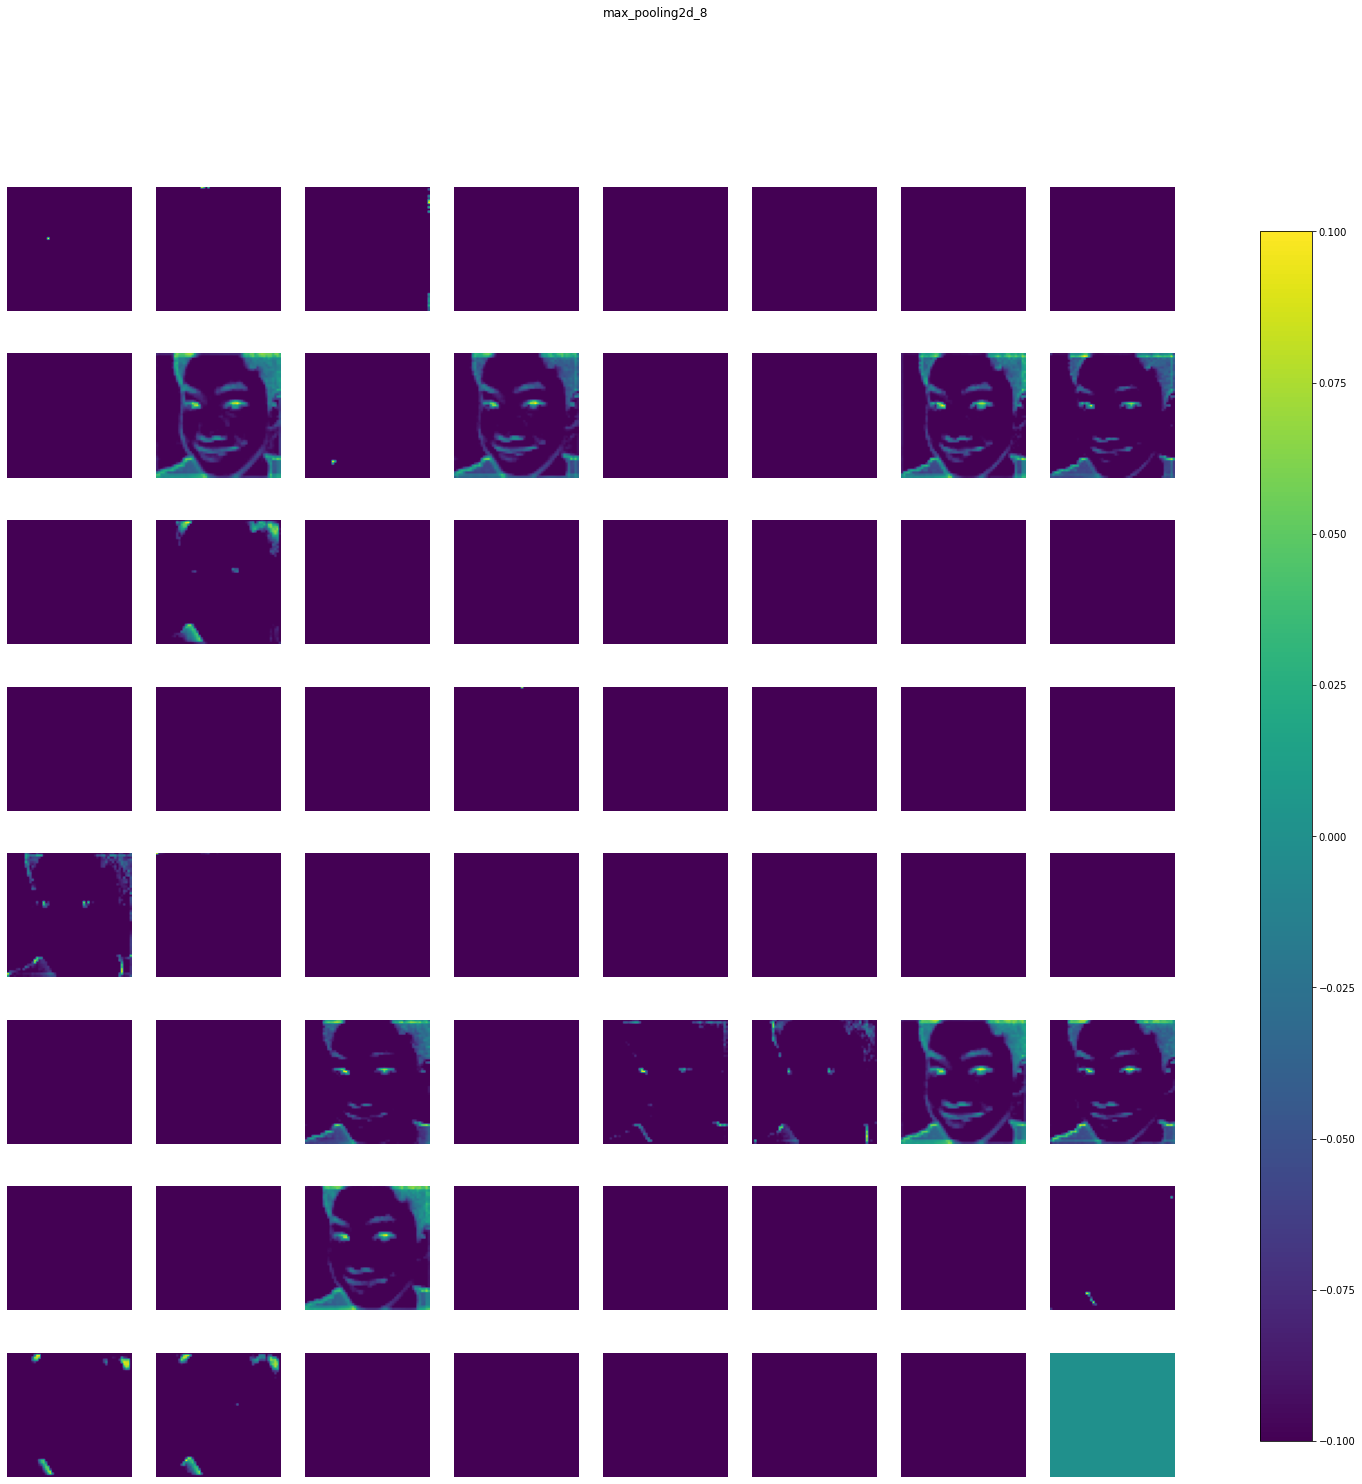

dropout (1, 56, 56, 64) 


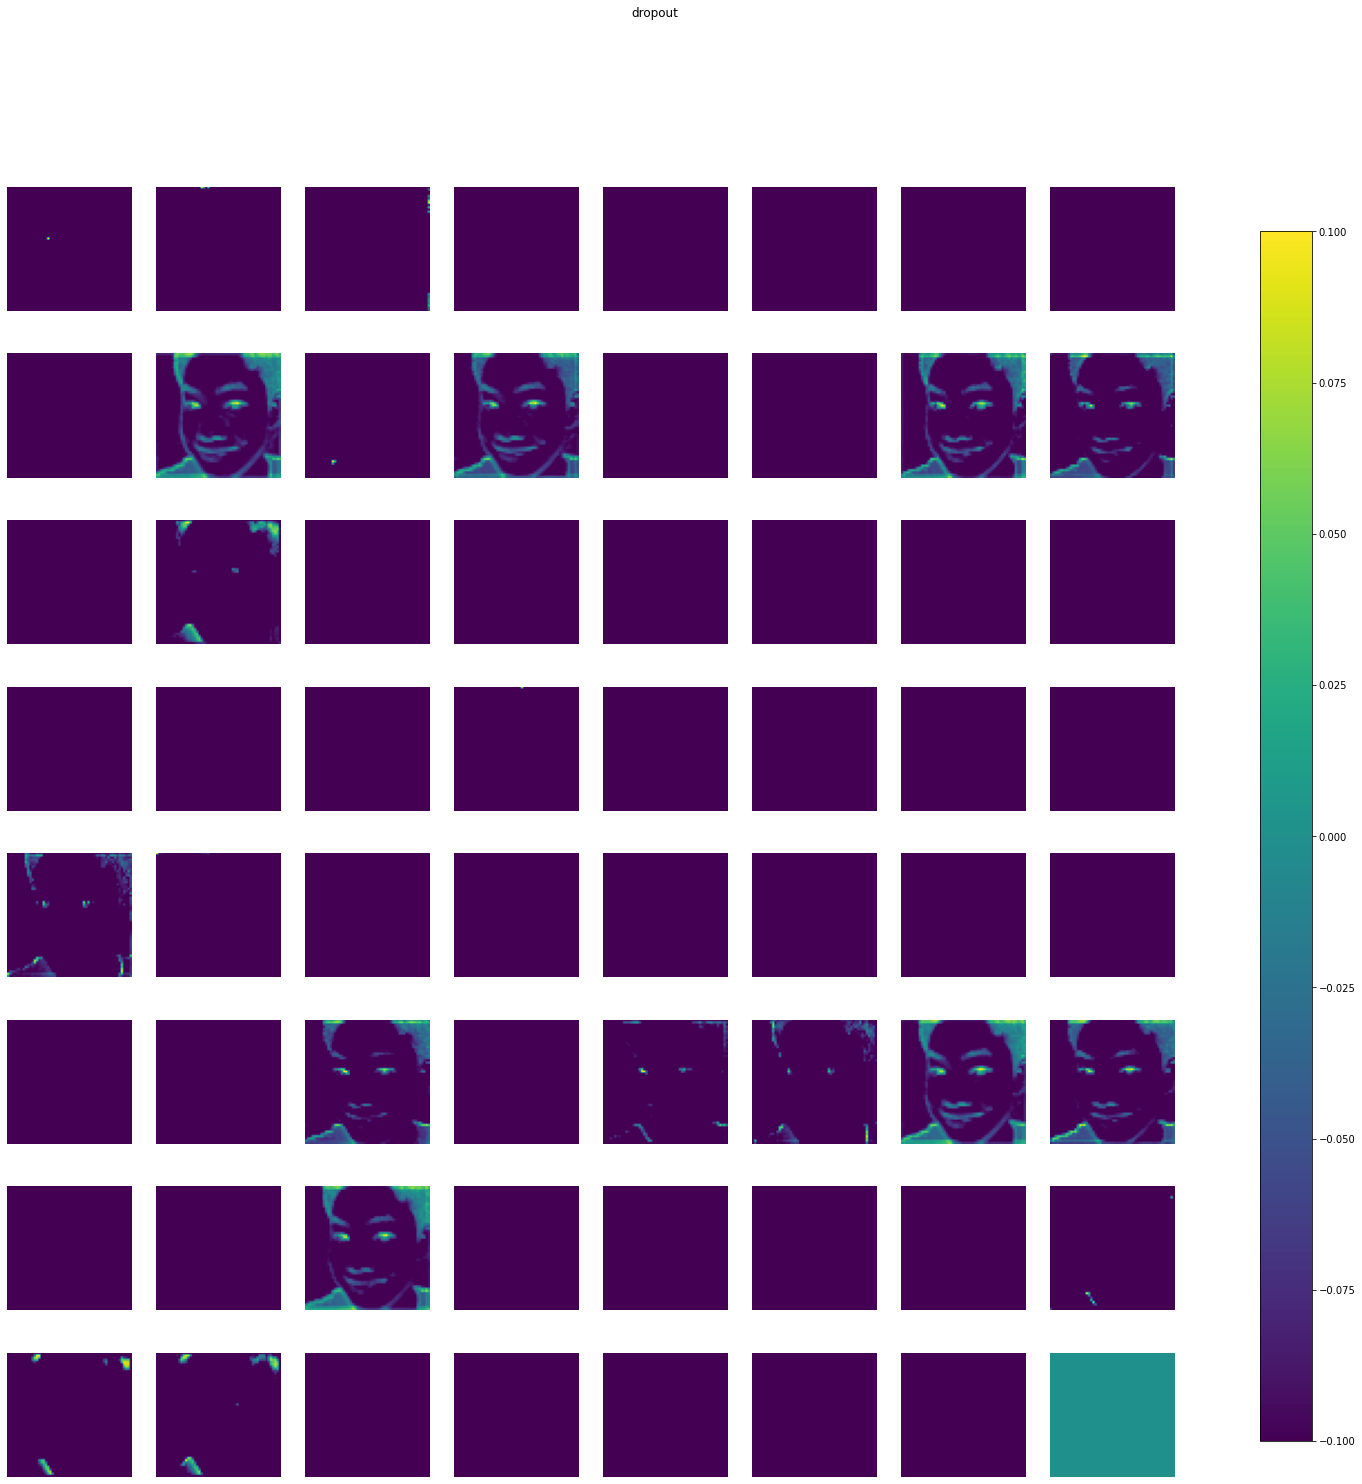

flatten_3 (1, 200704) 


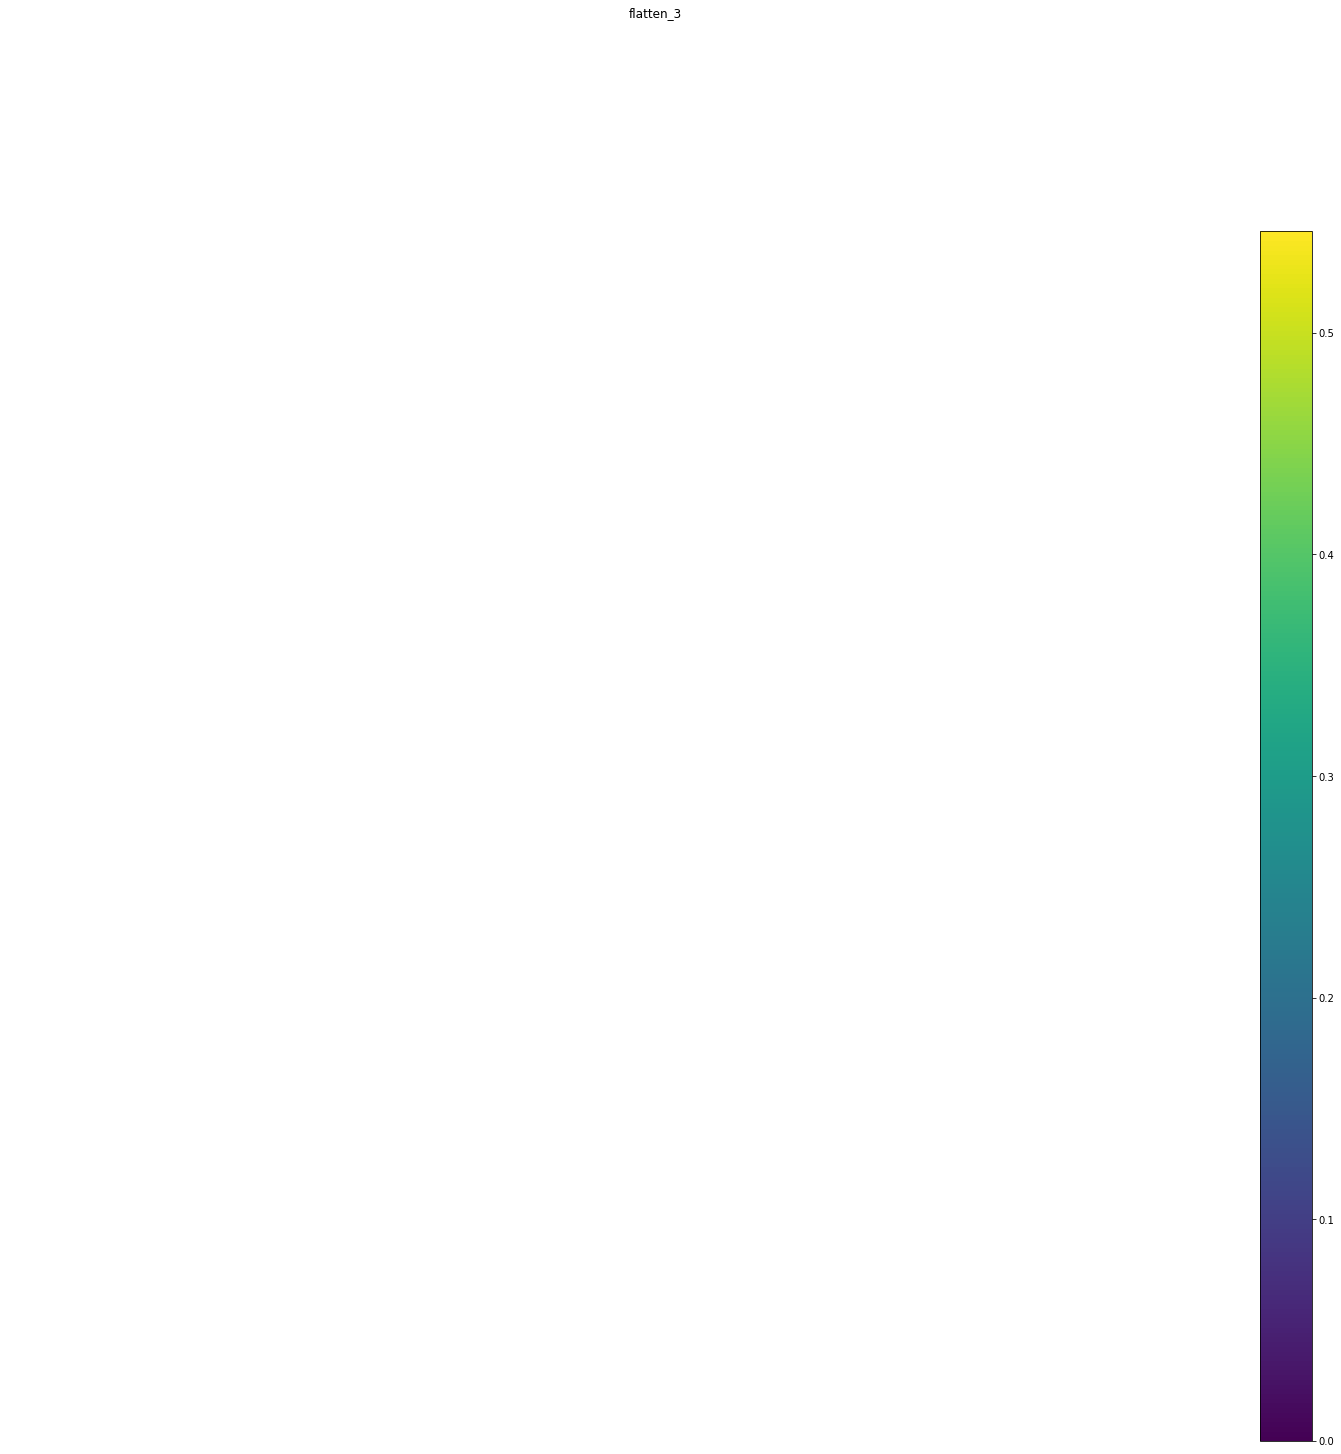

dense_6 (1, 128) 


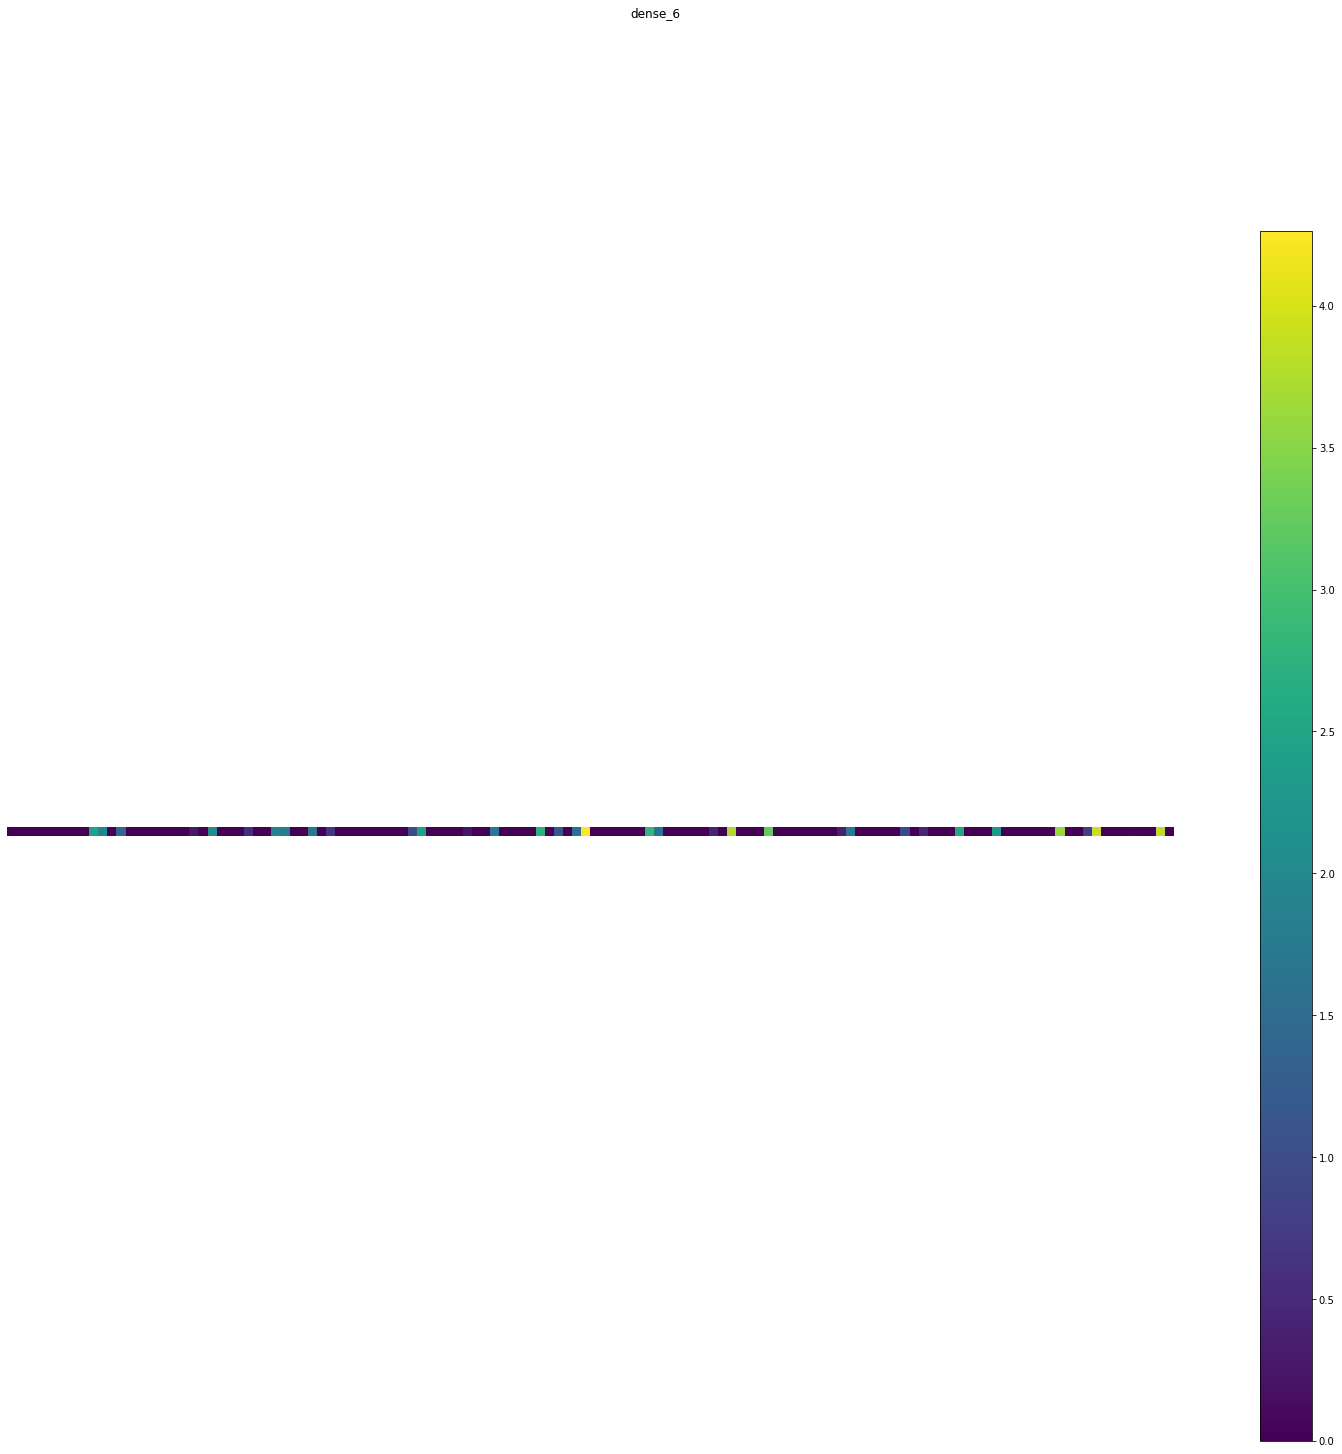

dropout_1 (1, 128) 


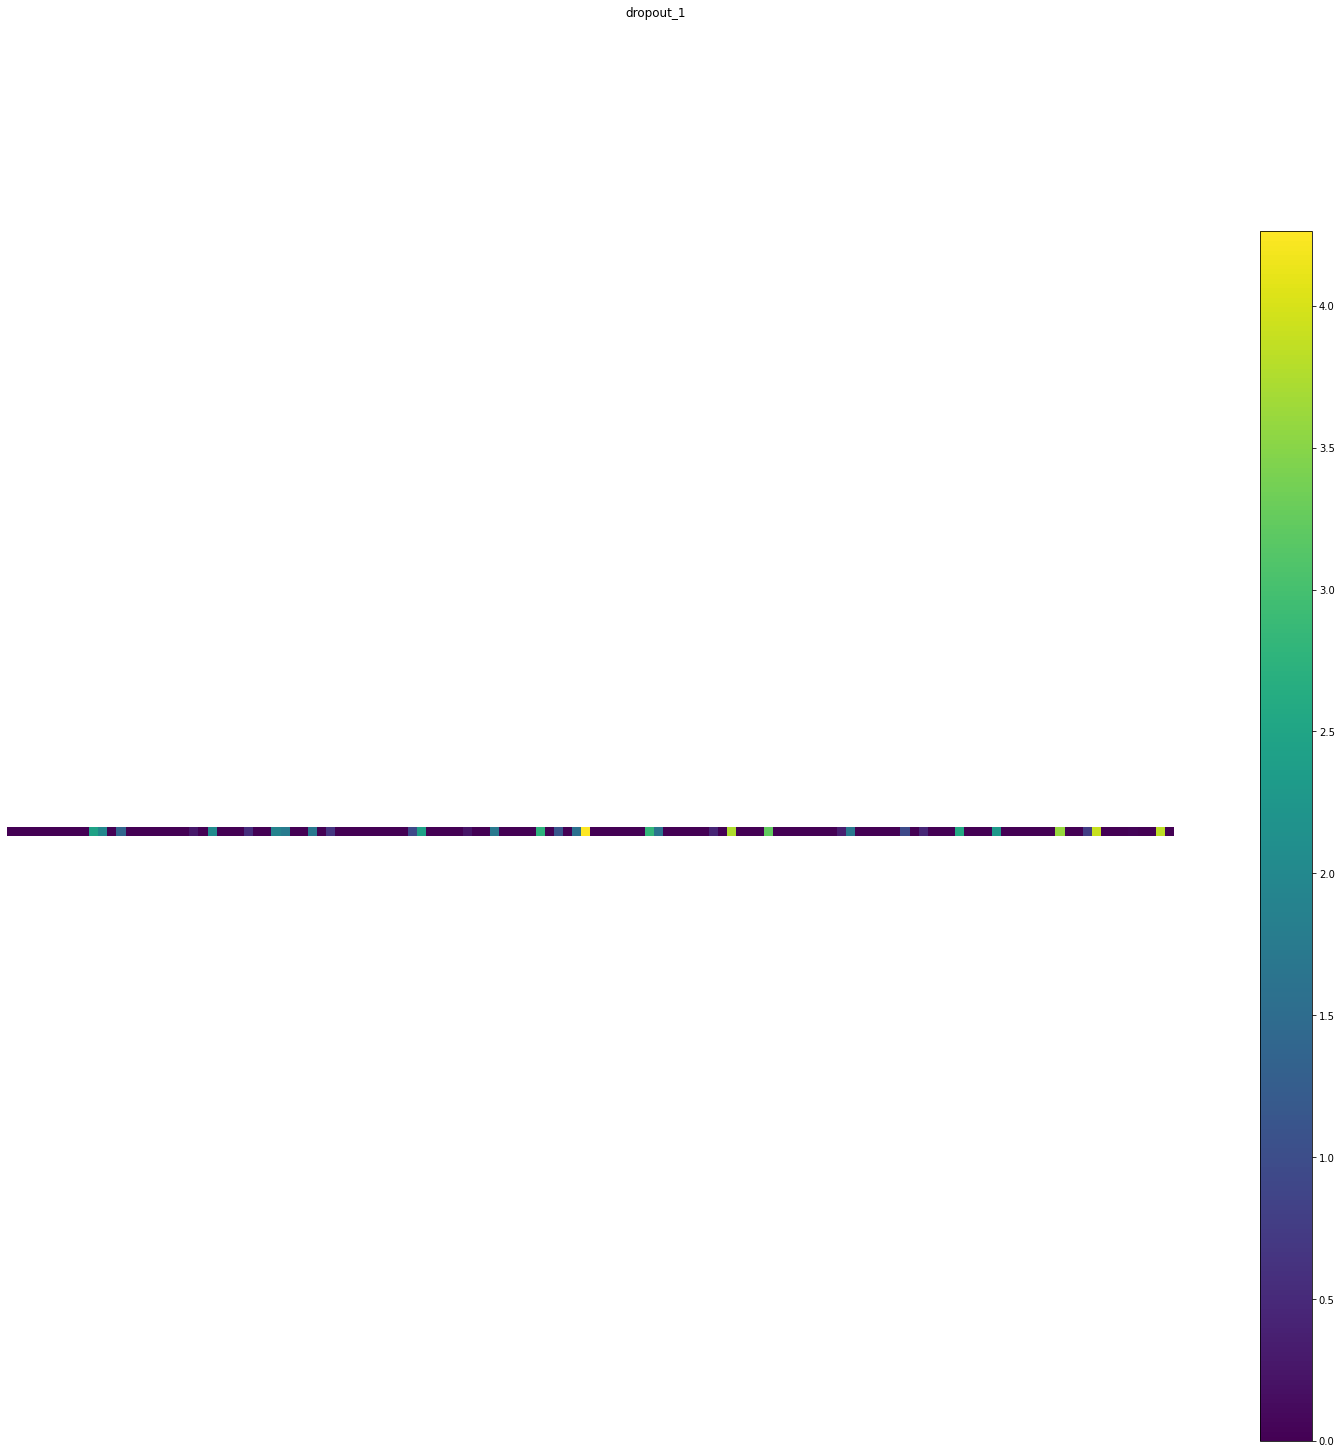

dense_7 (1, 4) 


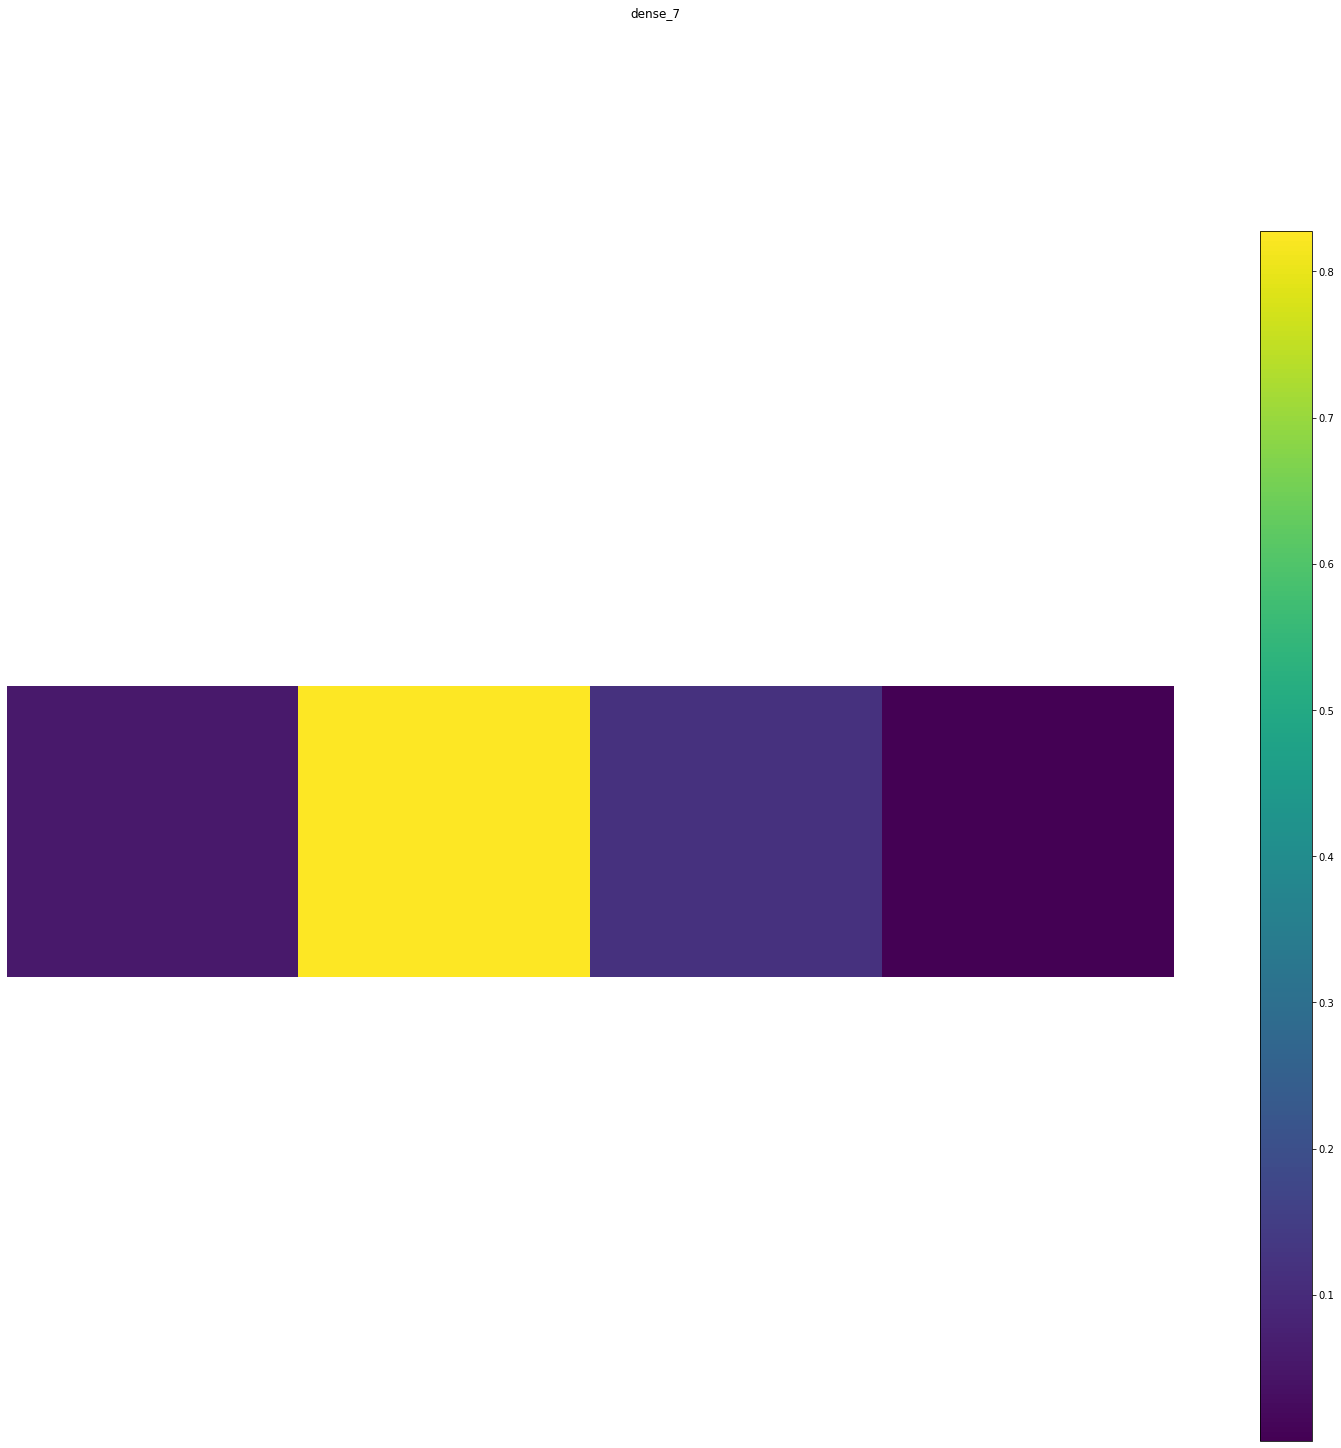

In [90]:
display_activations(activations=activations)

By looking at the visualisation above, we can see how our image is being ran through the layers in the model.

---

## Conclusion and Recommendations

**Conclusion**

To conclude this notebook, I would consider this to be a **success**. We have looked at many different ways and technique to help increase generalizability of our model. E.g. by cropping my face to reduce noise, applying image augmentation, using dropout layers as well as implementing earlystopping and model checkpoints. 

We also managed to hit a **recall for angry faces of 100%** which surpasses our target of 80%. Overall, I would say that this model exceeded expectation. 

**Limitations**

Some limitations I have is time, with more time, we will be able to test out even more complex models and tune even more parameters.

**Recommendations**

More photos and expressions could be implemented into the model to further increase generalizability of the model to unseen data.

Currently, this model is only trained using pictures of me. In the future, photos of others can be collected so that the model will be able to generalize on other types of faces and their facial expressions. 

---

To be continued... 

Join me on phase 2 where we apply transfer learning on a dataset from Kaggle! 

---